In [350]:
import pandas as pd 
import numpy as np 

import matplotlib
import matplotlib.pyplot as plt 
#%matplotlib inline 
#%config InlineBackend.figure_format = 'svg'
plt.style.use('ggplot') 
import plotly.graph_objects as go 
import seaborn as sns 

import re # for cleaning contact data

from sklearn.preprocessing import StandardScaler 
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA

from sklearn.cluster import KMeans 
from yellowbrick.cluster import KElbowVisualizer 

import scipy.stats as stats


In [410]:
path = 'C:/Users/C973119/Downloads/VSC/Client/Customer Segmentation/all/data/'
calls = pd.read_parquet(path + 'calls.parquet')
noti = pd.read_parquet(path + 'noti.parquet')
sessions = pd.read_parquet(path + 'sessions.parquet')
accounts = pd.read_parquet(path + 'accounts.parquet')
#demo = pd.read_parquet(path + 'demo.parquet')

print(calls.head(), '\n', noti.head(), '\n', sessions.head())

  name_customer  ivr_calls  csr_calls
0    8869451000          1          0
1    7154431936          1          0
2    1403041674          8          1
3    7993120000          1          0
4    9696850000          1          0 
            recipient  sms_noti  email_noti
0         2678845368        24           0
1         4843472303        13           0
2         4432541564        15           0
3         4102797976        27           0
4  ameza12@gmail.com         0           2 
    customerid channel  total_sessions        avg_session_time  enroll_alert  \
0  1990130000     app               1    37.31000000000000000             0   
1  4819448941     app               2   580.16099800000000000             0   
2  4813876603     app               3   192.86234833300000000             0   
3  9628071000     app              12   858.56542541700000000             0   
4  0942612930     app               3  4242.21800000000000000             0   

   view_map  report  view_tracker  

In [626]:
contacts = pd.read_parquet(path + 'cust_contact.parquet') 
csat = pd.read_excel(path + 'csat.xlsx')
cmi = pd.read_excel(path + 'cmi.xlsx', dtype= {'NAME_ACCT_ID': str})

print(contacts.head(), '\n', csat.head(), '\n', cmi.head())

  name_customer   type                 contact
0    0000631000  phone          (410) 247-8333
1    0000631000  email     irisob123@gmail.com
2    0000738679  phone          (646) 229-8927
3    0000738679  email  jade.clark94@gmail.com
4    0004904083  phone          (443) 488-3166 
    Survey ID        Responsedate  Form ID                        Form Name  \
0    2993190 2024-07-31 20:51:58    656.0  BGE Embedded - Report an Outage   
1    2992963 2024-07-31 19:38:55    656.0  BGE Embedded - Report an Outage   
2    2992962 2024-07-31 19:38:15    656.0  BGE Embedded - Report an Outage   
3    2993066 2024-07-31 19:21:01    656.0  BGE Embedded - Report an Outage   
4    2993008 2024-07-31 19:19:21    656.0  BGE Embedded - Report an Outage   

   csat  ease                         Improve Experience Comment Customer ID  \
0    10     5  Continue to send updates when things are not f...         NaN   
1     0     1       Turn my power back on. Ita been over 6 hours         NaN   
2     0

In [412]:
accounts.head()

,name_customer,name_customer_account,account_age
0,0000082207,5209213489,11.322581
1,0000401000,9331204667,22.129032
2,0000665102,0807395866,48.677419
3,0001480000,5925040000,224.677419
4,0001561370,0576917866,13.064516


## I. Cleaning and EDA

### 1. Cleaning

#### 1.Cleaning web & app data

In [413]:
pivot_sessions = sessions.pivot(index='customerid', columns='channel',
                                values=['total_sessions',
                                        'avg_session_time',
                                        'enroll_alert',
                                        'view_map',
                                        'report',
                                        'view_tracker',
                                        'other'])
pivot_sessions.columns = ['_'.join(col).strip() for col in pivot_sessions.columns.values]
pivot_sessions = pivot_sessions.reset_index()

In [414]:
s_columns = ['total_sessions_app',
 'total_sessions_web',
 'avg_session_time_app',
 'avg_session_time_web',
 'enroll_alert_app',
 'enroll_alert_web',
 'view_map_app',
 'view_map_web',
 'report_app',
 'report_web',
 'view_tracker_app',
 'view_tracker_web',
 'other_app',
 'other_web']

for col in s_columns:
    pivot_sessions[col] = pd.to_numeric(pivot_sessions[col])

#### 1.Cleaning notification data 

In [681]:
def clean_contact(text):
    phone_regex = r'\(?\d*\)?\s*\d+[-.\s]*\d+[-.\s]*\d+' 
    if re.match(phone_regex, text):
        return re.sub(r'[()\s.-]', '', text)
    return text 

In [682]:
contacts['contact'] = contacts['contact'].apply(clean_contact) 


In [683]:
noti['recipient'] = noti['recipient'].str.lower()
noti = noti.groupby('recipient')[['sms_noti', 'email_noti']].sum().reset_index()

contacts['contact'] = contacts['contact'].str.lower()
contacts.drop_duplicates(inplace=True)

In [418]:
# merge noti and contacts --> data at customerid level
notif = noti.merge(contacts, how='inner', left_on='recipient', right_on='contact')

notif.drop(columns=['type', 'contact', 'recipient'], inplace=True)


In [419]:
notif = notif.groupby('name_customer')[['email_noti', 'sms_noti']].sum().reset_index()

### Cleaning CSAT data

In [637]:
csat['Contact Number'] = csat['Contact Number'].astype(str)
csat['Contact Number'] = csat['Contact Number'].apply(clean_contact)

In [642]:
csat.head()

,Survey ID,Responsedate,Form ID,Form Name,csat,ease,Improve Experience Comment,Customer ID,Contact Number,CustomerId,OutageId
0,2993190,2024-07-31 20:51:58,656.0,BGE Embedded - Report an Outage,10,5,Continue to send updates when things are not f...,NaN,2403750958,NaN,NaN
1,2992963,2024-07-31 19:38:55,656.0,BGE Embedded - Report an Outage,0,1,Turn my power back on. Ita been over 6 hours,NaN,4432541670,NaN,NaN
2,2992962,2024-07-31 19:38:15,656.0,BGE Embedded - Report an Outage,0,1,NaN,NaN,4432213291,NaN,NaN
3,2993066,2024-07-31 19:21:01,656.0,BGE Embedded - Report an Outage,4,2,Plz make a workaround if you dont have acct nu...,NaN,3016412354,NaN,NaN
4,2993008,2024-07-31 19:19:21,656.0,BGE Embedded - Report an Outage,5,4,NaN,NaN,3017897843,NaN,NaN


In [653]:
def kpi_csat(df):
    score = sum(df['csat'] > 5) / len(df) * 100.0
    return score

def kpi_ease(df):
    score = sum(df['ease'] > 3) / len(df) * 100.0
    return score

In [684]:
csat_clean = csat.groupby('Contact Number').apply(lambda x: pd.Series({'csat': kpi_csat(x), 'ease': kpi_ease(x)})).reset_index()

In [685]:
csat_clean

,Contact Number,csat,ease
0,1443616617,0.000000,0.00000
1,2012070919,0.000000,0.00000
2,2012131357,100.000000,100.00000
3,2012186238,0.000000,0.00000
4,2012401070,0.000000,0.00000
...,...,...,...
17903,9858553070,100.000000,100.00000
17904,9859741271,100.000000,100.00000
17905,9892745003,0.000000,0.00000
17906,9896193694,0.000000,0.00000


In [686]:
csat_custid = csat_clean.merge(contacts, how='inner', left_on='Contact Number', right_on='contact')

In [687]:
csat_custid.drop(columns=['Contact Number', 'type', 'contact'], inplace=True)

In [688]:
csat_custid = csat_custid.groupby('name_customer')[['csat', 'ease']].mean().reset_index()

### Cleaning outage data

In [425]:
def account_clean(text):
    text = text[:10]
    return text 


In [426]:
cmi['NAME_ACCT_ID'] = cmi['NAME_ACCT_ID'].apply(account_clean)

In [427]:
cmi = cmi.merge(accounts, how='inner', left_on='NAME_ACCT_ID', right_on='name_customer_account')
cmi.drop(columns=['NAME_ACCT_ID', 'name_customer_account'], inplace=True)

In [428]:
cmi = cmi.groupby('name_customer').agg({'cmi':'mean', 'outages':'sum', 'account_age':'mean'}).reset_index()

#### 1.Joining all together --> user behaviors dataset

In [429]:
# joining sessions, notification, and call behaviors 
pivot_sessions.rename(columns={'customerid': 'name_customer'}, inplace=True)
#demo.rename(columns={'id':'name_customer'}, inplace=True)

In [474]:
behaviors = pivot_sessions.merge(notif, how='inner', on='name_customer').merge(calls, how='inner', on='name_customer').merge(cmi, how='inner', on='name_customer')

In [475]:
behaviors.replace(np.nan, 0, inplace=True)

### 2. Exploratory data analysis

In [513]:
features = ['total_sessions_app', 
 'total_sessions_web',
 'email_noti',
 'sms_noti',
 'ivr_calls',
 'csr_calls',
 'cmi']

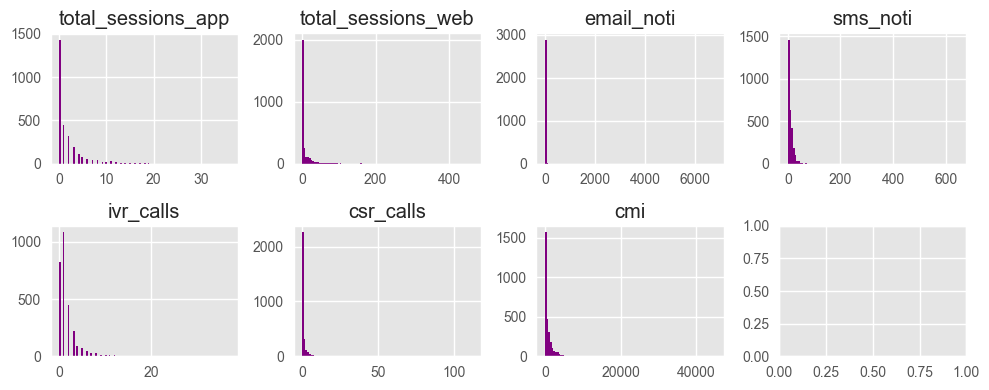

In [582]:
fig, axes = plt.subplots(2,4, figsize = (10,4))

for feature, ax in zip(features, axes.ravel()):
    ax.hist(behaviors[feature], bins=100, color='purple')
    ax.set_title(feature)

plt.tight_layout() # avoid overlapping

c:\Users\C973119\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\C973119\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\C973119\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\C973119\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\C973119\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\C973119\AppData\Local\anaconda3\Lib\site-packages\seaborn\axisgrid.py:1507: UserWarning:

Ignoring `palette` because no `hue` variable has been assigned.

c:\Users\C973119

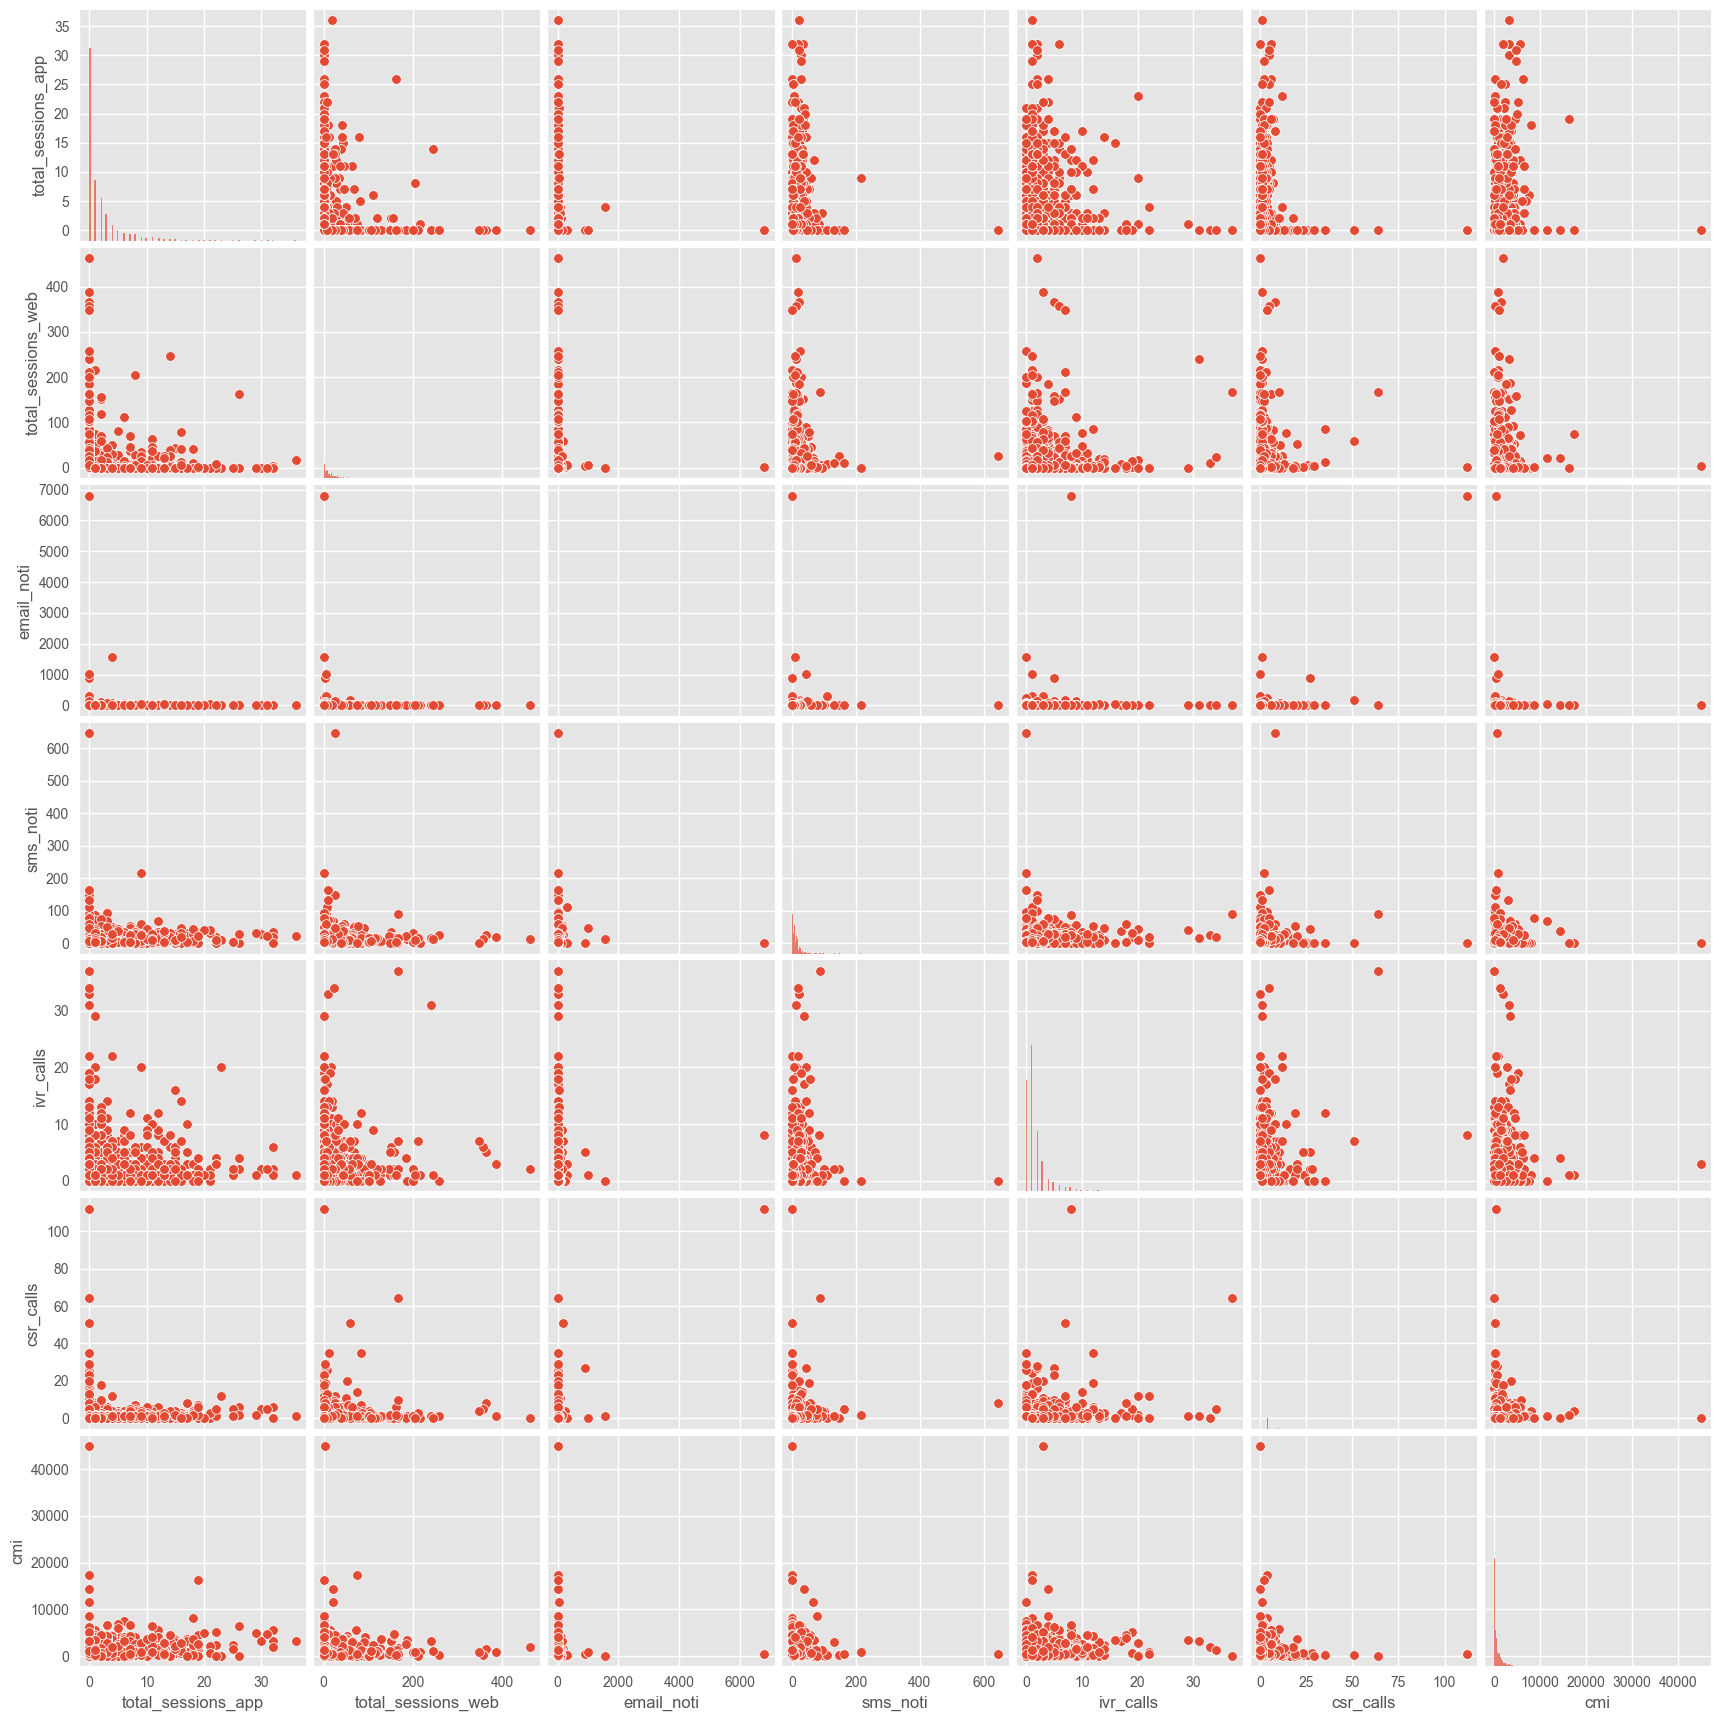

In [587]:
sns.pairplot(behaviors, vars=features, palette='viridis')

## Standardization

In [516]:
behaviors_np = behaviors[features].to_numpy() 

behaviors_np.shape

(2914, 7)

In [517]:
# standard scaling data for better PCA performance
scaler = StandardScaler()
behaviors_np = scaler.fit_transform(behaviors_np)

behaviors_np[:, 0].std()

1.0

## II. Principal Component Analysis

### PCA

In [518]:
pca = PCA(n_components=2)
behaviors_2_result = pca.fit_transform(behaviors_np)

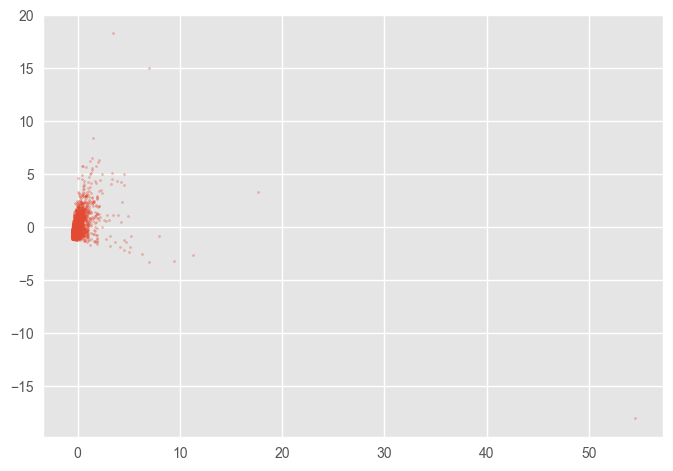

In [519]:
plt.scatter(behaviors_2_result[:,0], behaviors_2_result[:,1], s=2, alpha=0.3)

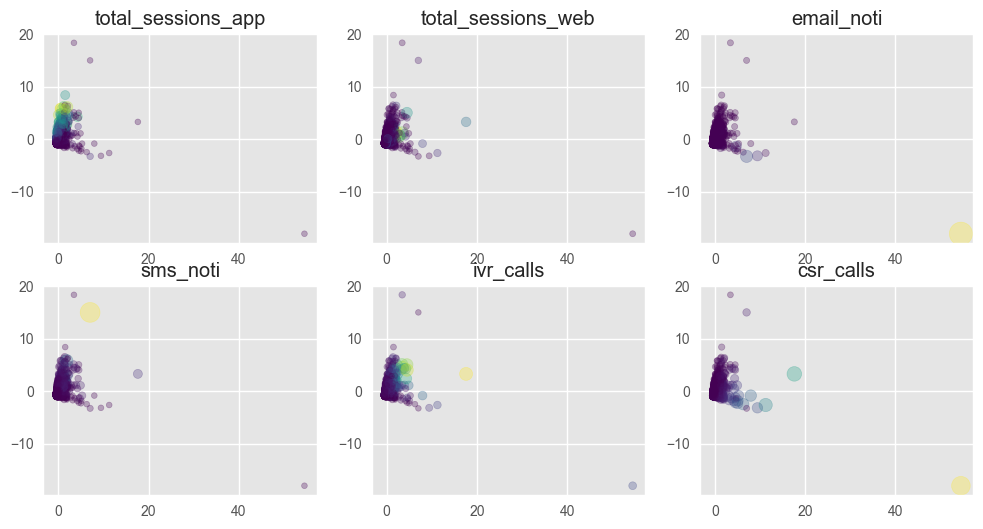

In [520]:
fig, axes = plt.subplots(2, 3, figsize = (12,6))
for feature, ax in zip(features, axes.ravel()):
    cmap = 'viridis'
    size = 20 + 5* behaviors_np[:, features.index(feature)]
    color = behaviors[feature]
    ax.scatter(behaviors_2_result[:,0], behaviors_2_result[:,1], c=color, s= size, cmap=cmap, alpha=0.3)
    ax.set_title(feature)

### Kernel PCA

#### Polymonial function

In [521]:
kpca = KernelPCA(n_components=2, kernel='poly', degree=2)

behaviors_result_poly = kpca.fit_transform(behaviors_np)


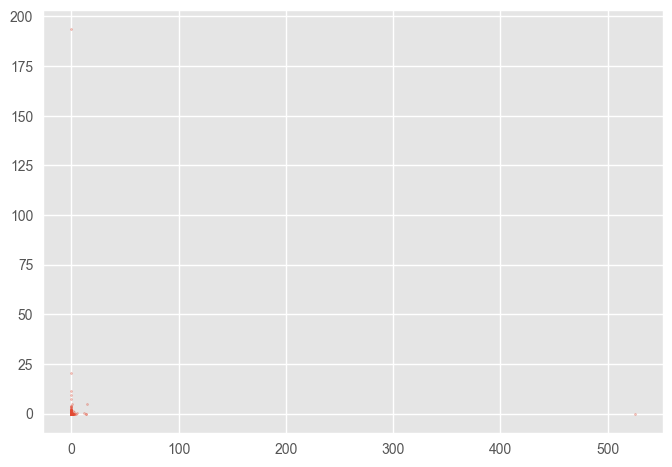

In [522]:
plt.scatter(behaviors_result_poly[:,0], behaviors_result_poly[:,1], s=2, alpha=0.3)

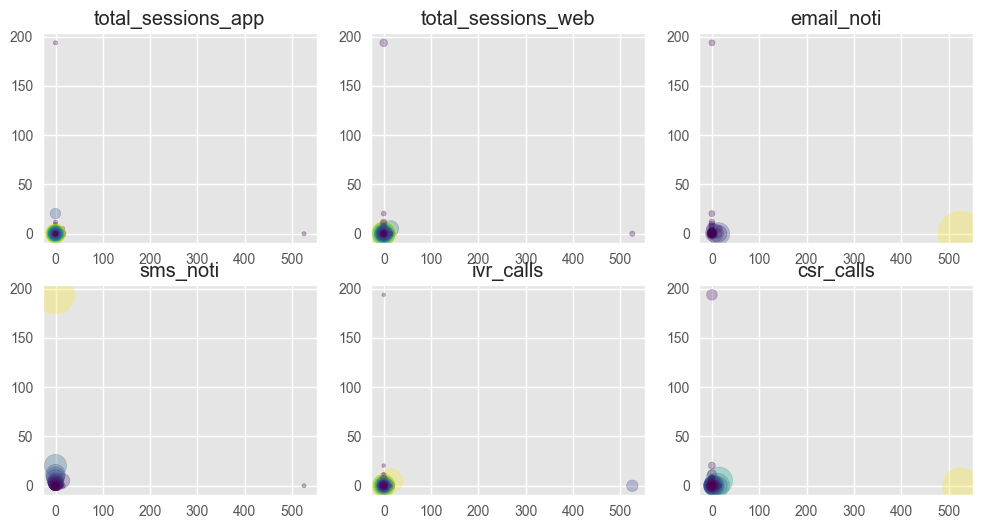

In [523]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))
for feature, ax in zip(features, axes.ravel()):
    cmap = 'viridis'
    size = 20 + 20* behaviors_np[:, features.index(feature)]
    color = behaviors[feature]
    ax.scatter(behaviors_result_poly[:,0], behaviors_result_poly[:,1], c=color, s= size, cmap=cmap, alpha=0.3)
    ax.set_title(feature)

#### Radial Basis Function

In [524]:
kpca = KernelPCA(n_components=2, kernel='rbf', gamma= 0.01)

behaviors_result_rbf = kpca.fit_transform(behaviors_np)

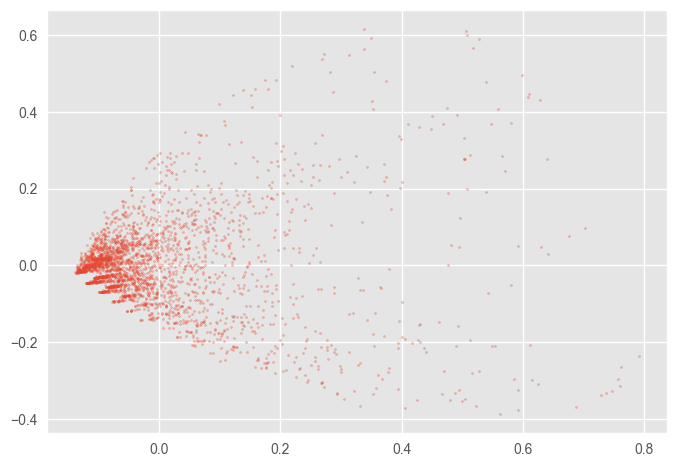

In [525]:
plt.scatter(behaviors_result_rbf[:,0], behaviors_result_rbf[:,1], s=2, alpha=0.3)

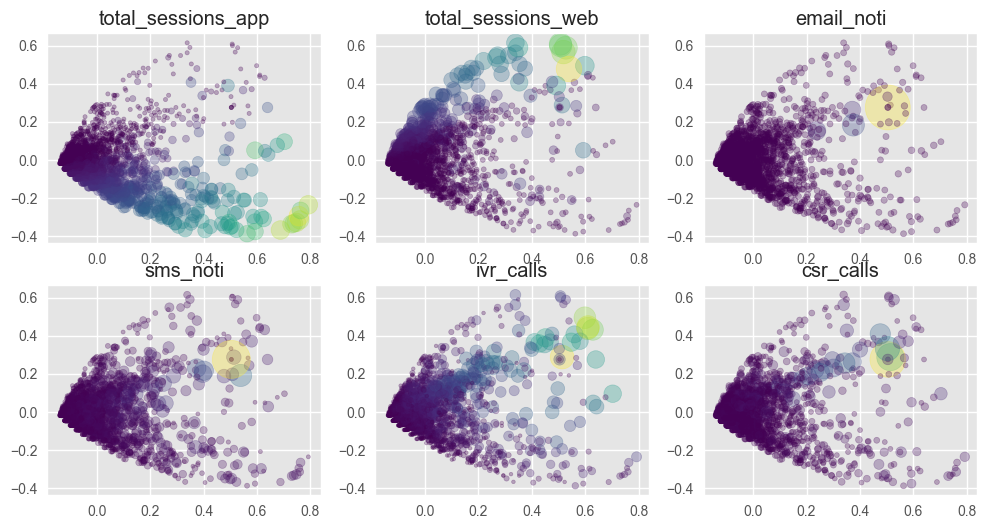

In [526]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))
for feature, ax in zip(features, axes.ravel()):
    cmap = 'viridis'
    size = 20 + 20* behaviors_np[:, features.index(feature)]
    color = behaviors[feature]
    ax.scatter(behaviors_result_rbf[:,0], behaviors_result_rbf[:,1], c=color, s= size, cmap=cmap, alpha=0.3)
    ax.set_title(feature)

In [527]:
#### Cosine function

In [528]:
kpca = KernelPCA(n_components=2, kernel='cosine')
behaviors_result_cos = kpca.fit_transform(behaviors_np)

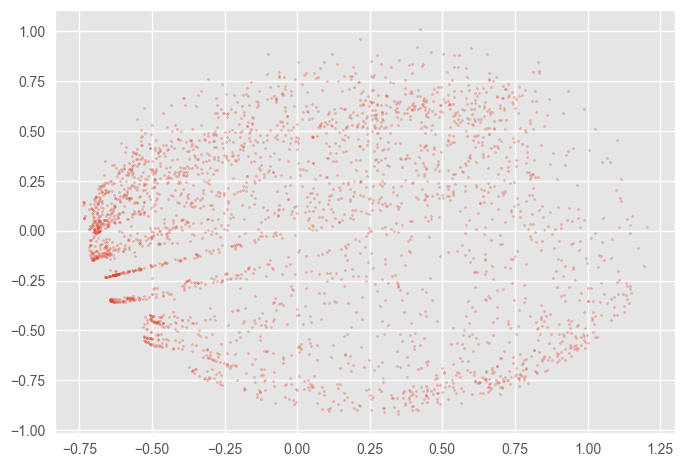

In [529]:
plt.scatter(behaviors_result_cos[:,0], behaviors_result_cos[:,1], s=2, alpha=0.3)

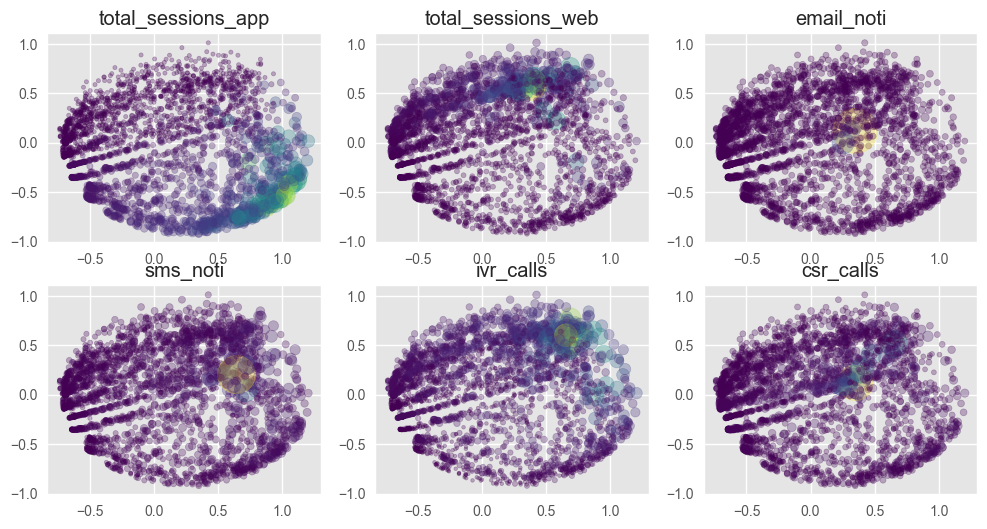

In [530]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))
for feature, ax in zip(features, axes.ravel()):
    cmap = 'viridis'
    size = 20 + 20* behaviors_np[:, features.index(feature)]
    color = behaviors[feature]
    ax.scatter(behaviors_result_cos[:,0], behaviors_result_cos[:,1], c=color, s= size, cmap=cmap, alpha=0.3)
    ax.set_title(feature)

#### Sigmoid function

In [531]:
kpca = KernelPCA(n_components=2, kernel='sigmoid', gamma=0.01, degree=2)

behaviors_result_sig = kpca.fit_transform(behaviors_np)

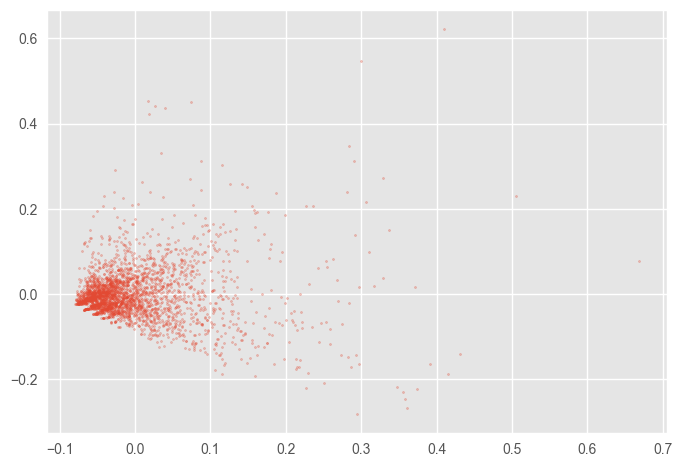

In [532]:
plt.scatter(behaviors_result_sig[:,0], behaviors_result_sig[:,1], s=2, alpha=0.3)

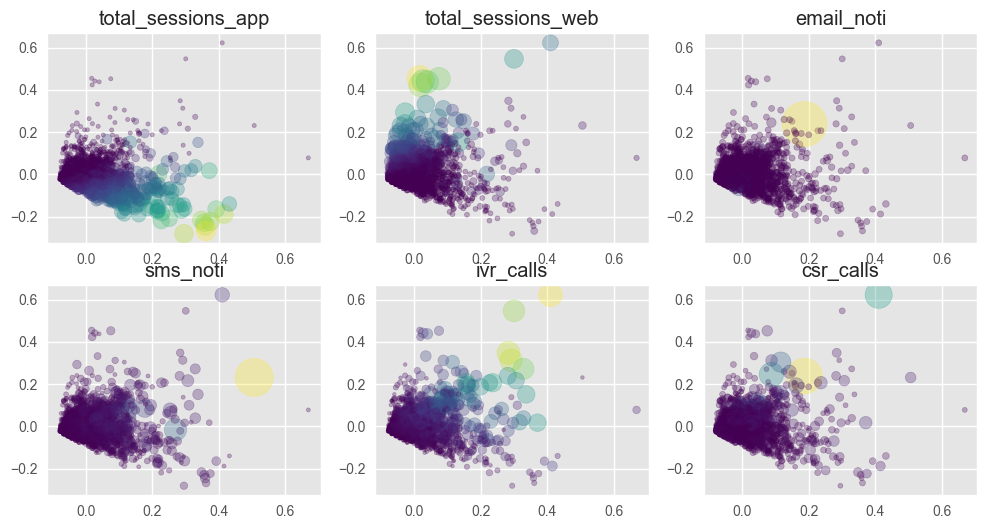

In [533]:
fig, axes = plt.subplots(2, 3, figsize = (12, 6))
for feature, ax in zip(features, axes.ravel()):
    cmap = 'viridis'
    size = 20 + 20* behaviors_np[:, features.index(feature)]
    color = behaviors[feature]
    ax.scatter(behaviors_result_sig[:,0], behaviors_result_sig[:,1], c=color, s= size, cmap=cmap, alpha=0.3)
    ax.set_title(feature)

## Customer segmentation

In [588]:
# clustering with KMeans
clusterer = KMeans(n_clusters=3, n_init = 20, max_iter=500, random_state=123)
clusters = clusterer.fit_predict(behaviors_result_rbf)

In [552]:
markers = list('*hH+xXDd|.,ov^<>12348spP')

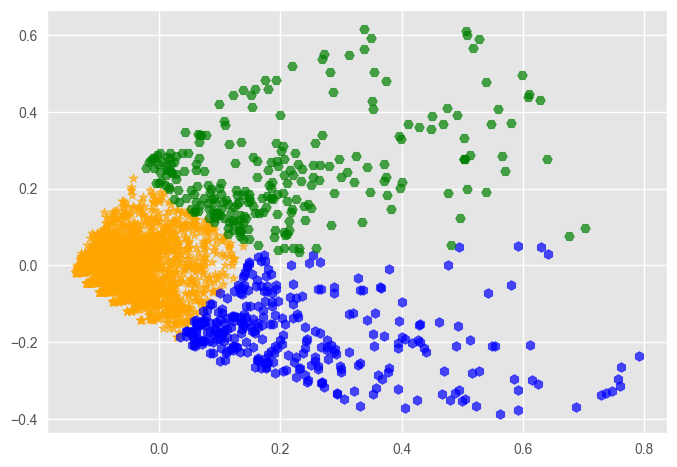

In [604]:
cluster_colors = ['orange', 'blue', 'green']
for cluster in np.unique(clusters):
    cluster_data = behaviors_result_rbf[clusters==cluster]
    plt.scatter(cluster_data[:,0], cluster_data[:,1], alpha=0.7, marker=markers[cluster], color=cluster_colors[cluster])

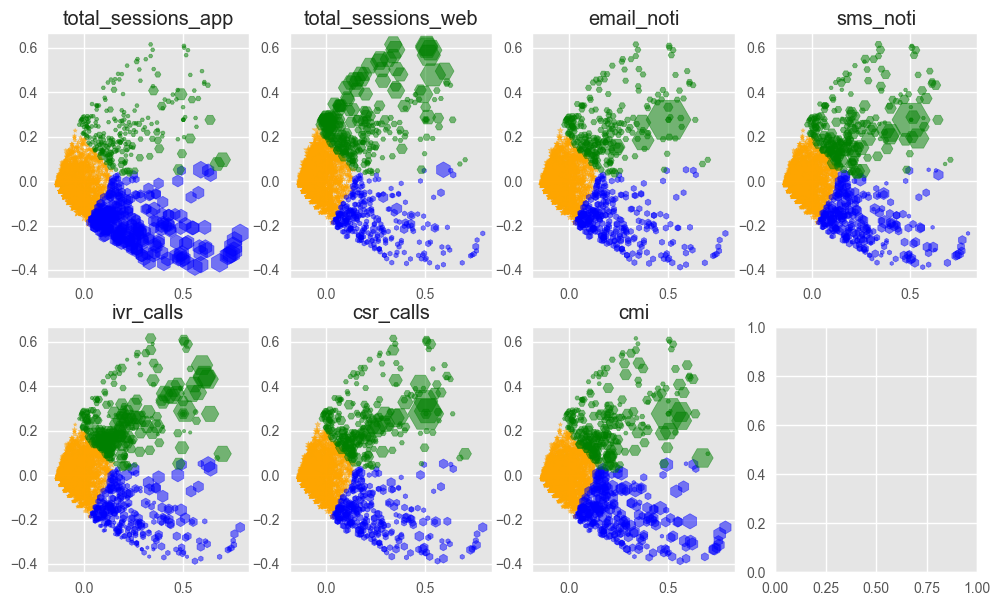

In [612]:
fig, axes = plt.subplots(2, 4, figsize = (12, 7))
cluster_colors = ['orange', 'blue', 'green']
for feature, ax in zip(features, axes.ravel()):
    
    for cluster in np.unique(clusters):
        cluster_data = behaviors_result_rbf[clusters == cluster]
        size = 20 + 20* behaviors_np[:, features.index(feature)][clusters == cluster]
        ax.scatter(cluster_data[:,0], cluster_data[:,1], s=size, color=cluster_colors[cluster], alpha=0.5, marker=markers[cluster])
    ax.set_title(feature)

### Elbow analysis for K-Means

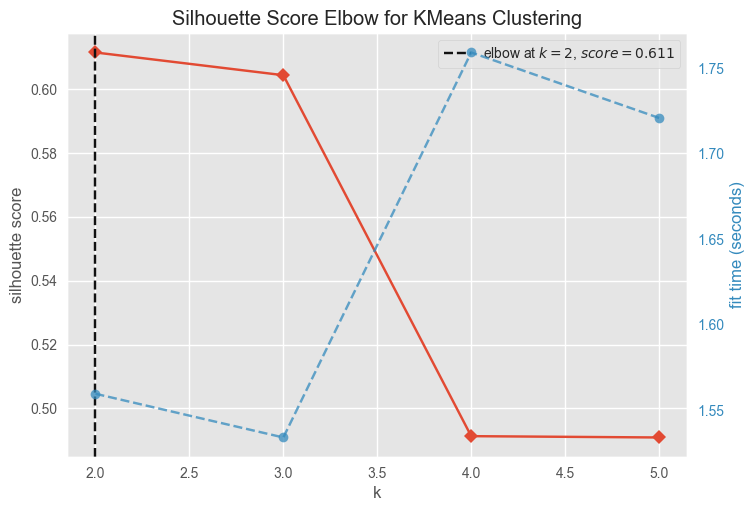

<Axes: title={'center': 'Silhouette Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='silhouette score'>

In [591]:
# Elbow viz
viz = KElbowVisualizer(clusterer, k=(2,6), metric='silhouette')
viz.fit(behaviors_result_rbf)

viz.show()

In [592]:
behaviors['cluster'] = clusters

In [617]:
behaviors.to_csv(path + 'output.csv', index=False)

In [593]:

data = behaviors[features + ['cluster']]


In [594]:
data.groupby('cluster')[features].mean()

,total_sessions_app,total_sessions_web,email_noti,sms_noti,ivr_calls,csr_calls,cmi
cluster,,,,,,,
0,1.062152,6.316760,4.478783,7.749679,1.245607,0.961852,586.028989
1,10.155763,2.950156,5.283489,14.953271,1.971963,1.274143,1741.062422
2,0.807692,54.453846,47.853846,24.950000,5.542308,3.996154,1902.833787


In [595]:
data.groupby('cluster')[features].count()

,total_sessions_app,total_sessions_web,email_noti,sms_noti,ivr_calls,csr_calls,cmi
cluster,,,,,,,
0,2333,2333,2333,2333,2333,2333,2333
1,321,321,321,321,321,321,321
2,260,260,260,260,260,260,260


In [596]:
data_normalized = data.copy(deep=True)
data_normalized.loc[:, features] = behaviors_np
data_normalized['cluster'] = clusters

# data_normalized[features] /= data_normalized[features].max()


In [615]:
# Kernel PCA Sigmoid function
fig = go.Figure()

for cluster in np.unique(clusters):
    radius = data_normalized.loc[data_normalized.cluster == cluster, features].mean() #/ data_normalized.loc[data_normalized.cluster == cluster, features].mean().max()
    thetas = features 
    actual_val = data.loc[data_normalized.cluster == cluster, features].mean()
    cluster_size = len(data[data.cluster == cluster])
    colors = ['orange', 'blue', 'green']
    fig.add_trace(
        go.Scatterpolar(r=radius, theta=thetas, mode='lines', name=f'Cluster {cluster}', text=[f'Mean value: {x}' for x in actual_val],
                        opacity=np.max([0.8, cluster_size / len(data[data.cluster == 0])]),
                        line=dict(width=np.max([1, 3*cluster_size / len(data[data.cluster == 0])]), color=colors[cluster])
                        )
        )

fig.update_layout(title='Customer Segmentation based on behavior', width=800, autosize=False,
                  polar=dict(
                        radialaxis=dict(
                            showticklabels=False  # remove radius label on radar
        )
    )
) #autosize false to not override variables
fig.show()

In [616]:
fig.write_html('C:/Users/C973119/Downloads/VSC/Client/Customer Segmentation/all/final.html')

## Statistical testing clusters'CSAT difference

#### Anova test

In [690]:
behaviors_outcomes = behaviors.merge(csat_custid, how='inner', on='name_customer')

In [691]:
behaviors_outcomes.groupby('cluster')[['ease', 'csat']].mean()

,ease,csat
cluster,,
0,55.917874,54.045894
1,65.000000,56.666667
2,56.595745,46.595745


In [692]:
# test on csat

cluster1 = behaviors_outcomes[behaviors_outcomes.cluster == 0]['csat']
cluster2 = behaviors_outcomes[behaviors_outcomes.cluster == 1]['csat']
cluster3 = behaviors_outcomes[behaviors_outcomes.cluster == 2]['csat']
f, p = stats.f_oneway(cluster1, cluster2, cluster3)

print(f, p)

0.4722663597314341 0.6242915416012689


In [693]:
# test on ease

cluster1 = behaviors_outcomes[behaviors_outcomes.cluster == 0]['ease']
cluster2 = behaviors_outcomes[behaviors_outcomes.cluster == 1]['ease']
cluster3 = behaviors_outcomes[behaviors_outcomes.cluster == 2]['ease']
f, p = stats.f_oneway(cluster1, cluster2, cluster3)

print(f, p)

0.23770394011924628 0.7886618877342507
